<a href="https://colab.research.google.com/github/albuut/Medical-Malpractice-Analysis/blob/main/CS203_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy import stats
from matplotlib import pyplot

# Medical Malpractice Analysis

# Google Colab Startup
Make sure to clone the repository into the Google Colab.

In [ ]:
!git clone https://github.com/albuut/Medical-Malpractice-Analysis.git

Cloning into 'Medical-Malpractice-Analysis'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 177 (delta 33), reused 15 (delta 10), pack-reused 126
Receiving objects: 100% (177/177), 865.70 KiB | 3.11 MiB/s, done.
Resolving deltas: 100% (90/90), done.


Run the following code.

In [ ]:
%cd /content/Medical-Malpractice-Analysis/

/content/Medical-Malpractice-Analysis


# Data Cleaning

Data manipulated from the original data set.

1. Amount: Log(Amount)

2. Speciality: Dummy variable encoded into different specialities.

3. Insurance: Dummy variable enconded into different insurances.

4. Marital Status: Dummy variable econded into different marital status.

5. Gender: One hot encoded gender for Male = 0 and Female = 1.

The data is also split into three categories.
1. Training: 60%
2. Validation: 20%
3. Testing: 20%

The decison to convert insurance and martial status to become dummy variable encoded was so that we did not have to worry about the numbering of the enumerated variables imply there was a form of ordinality.

Some things to consider for future development is to not remove the unknown's completely from the data set. There could be corrleations where divoriced people do not put their insurance information down. Future reticfication would be to think about how to assign some value to them. Another improvement could be using Stratified Sampling.





## proccess_data.py
```python
import pandas as pd
import numpy as np
import sys

def dummy_variable_col(df, col):
    df_temp = pd.get_dummies(df[col])
    df_temp = df_temp.astype(int)
    df = pd.concat([df,df_temp],axis=1,).reindex(df.index)
    df.drop(col,axis=1,inplace=True)
    return df

## python3 function_name input output log_base
errors = []

if(len(sys.argv) == 4):
    file_input = sys.argv[1]
    file_output = sys.argv[2]
    log_base = sys.argv[3]
else:
    errors.append("Invalid Number of Arguments")

if(len(errors) == 0):
    try:
        df = pd.read_csv(file_input)
    except Exception as e:
        errors.append("Invalid file input / Could not find file")
    
    if(len(errors) == 0):
        #Log the Data
        if log_base == '10':
            df['log_Amount'] = np.log10(df['Amount'])
        elif log_base == '2':
            df['log_Amount'] = np.log2(df['Amount'])
        elif log_base == 'ln':
            df['log_Amount'] = np.log(df['Amount'])
        else:
            errors.append('Invalid 3rd Argument: Use 10, 2, or ln')
        col_move = df.pop('log_Amount')
        df.insert(loc=1,column='log_Amount',value=col_move)
if(len(errors) == 0):
    #Speciality
    df = dummy_variable_col(df,'Specialty')
    #Insurance
    df = df[df['Insurance'].str.contains("Unknown") == False]
    df = dummy_variable_col(df,'Insurance')
    #Marital Status
    df = df[df['Marital Status'] != 4]
    df = dummy_variable_col(df,'Marital Status')
    df = df.rename(columns={0:'Divorced', 1:'Single', 2:'Married', 3:'Widowed'})
    #Gender Binary Encode
    df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
    
    #Shuffle Data and Split
    #Consider checking out stratified splitting
    train, validate, test = np.split(df.sample(frac=1),[int(0.6*len(df)),int(.8*len(df))])
    
    train = train.reset_index(drop=True) #60%
    validate = validate.reset_index(drop=True) #20%
    test = test.reset_index(drop=True) #20%
    
    total_data = len(train) + len(validate) + len(test)
    
    train.to_csv(file_output + '_train.csv', index=False)
    print("Successfully written data to: " + file_output + '_train.csv')
    validate.to_csv(file_output + '_validate.csv', index=False)
    print("Successfully written data to: " + file_output + '_validate.csv')
    test.to_csv(file_output + '_test.csv', index =False)
    print("Successfully written data to: " + file_output + '_test.csv')
    
else:
    for e in reversed(errors):
        print(e)
```

We can use the following lines to generate the cleaned up data from csv file with different log values down below.

In [ ]:
!python process_data.py medicalmalpractice.csv log10_data 10
!python process_data.py medicalmalpractice.csv log2_data 2
!python process_data.py medicalmalpractice.csv ln_data ln

Successfully written data to: log10_data_train.csv
Successfully written data to: log10_data_validate.csv
Successfully written data to: log10_data_test.csv
Successfully written data to: log2_data_train.csv
Successfully written data to: log2_data_validate.csv
Successfully written data to: log2_data_test.csv
Successfully written data to: ln_data_train.csv
Successfully written data to: ln_data_validate.csv
Successfully written data to: ln_data_test.csv


We then display the origonal data down below.

In [ ]:
df_original = pd.read_csv('medicalmalpractice.csv')
df_original

,Amount,Severity,Age,Private Attorney,Marital Status,Specialty,Insurance,Gender
0,57041,7,62,1,2,Family Practice,Private,Male
1,324976,6,38,1,2,OBGYN,No Insurance,Female
2,135383,4,34,1,2,Cardiology,Unknown,Male
3,829742,7,42,1,1,Pediatrics,No Insurance,Female
4,197675,3,60,0,2,OBGYN,Medicare/Medicaid,Female
...,...,...,...,...,...,...,...,...
79205,25305,4,64,1,2,General Surgery,Unknown,Male
79206,43098,3,87,0,4,Orthopedic Surgery,Unknown,Male
79207,35398,3,81,0,4,Anesthesiology,Unknown,Male
79208,154228,9,19,0,4,Dermatology,Unknown,Female


We can then observe how the data is cleaned and seperated into different variables to be used in different forms of regression or analysis.

In [ ]:
df_log10 = pd.read_csv('log10_data_train.csv')
df_log10

,Amount,log_Amount,Severity,Age,Private Attorney,Gender,Anesthesiology,Cardiology,Dermatology,Emergency Medicine,...,Thoracic Surgery,Urological Surgery,Medicare/Medicaid,No Insurance,Private,Workers Compensation,Divorced,Single,Married,Widowed
0,124869,5.096455,3,10,1,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
1,124730,5.095971,6,13,1,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,155554,5.191881,3,63,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,45040,4.653598,3,79,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,306016,5.485744,7,44,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29519,130256,5.114798,7,62,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
29520,193750,5.287242,3,69,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
29521,123714,5.092419,3,44,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
29522,22595,4.354012,3,56,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


# Bayesian Ridge Regression

Initalize variables and read data.

In [ ]:
base_file = 'ln_data'

#Untuned Bayesian Regression
base_regressor = BayesianRidge()
#Untuned Bayesian Regression with Transform
log_base_regressor = BayesianRidge()

#Tuned Bayesian Regression
tuned_regressor = BayesianRidge()
#Tuned Log Bayesian Regression
log_tuned_regressor = BayesianRidge()

#File suffixes
train_suffix = '_train.csv'
validate_suffix = '_validate.csv'
test_suffix = '_test.csv'

#Read Data from File
df_bay_train = pd.read_csv(base_file + train_suffix)
df_bay_validate = pd.read_csv(base_file + validate_suffix)
df_bay_test = pd.read_csv(base_file + test_suffix)

#Testing what happens when removing speciality
#df_bay_train = df_bay_train.drop(columns=df_bay_train.columns[6:26])
#df_bay_validate = df_bay_validate.drop(columns=df_bay_validate.columns[6:26])
#df_bay_test = df_bay_test.drop(columns=df_bay_test.columns[6:26])

#Extract our features and our Y
train_x, train_y, log_train_y = df_bay_train.drop(columns=['Amount','log_Amount']), df_bay_train['Amount'], df_bay_train['log_Amount']

#Seed values for initalized hyperparameters for RandomizedSearchCV
bayesian_param = {
    'alpha_init': np.linspace(1e-10,1e-2,num=100),
    'lambda_init': np.linspace(1e-10,1e-2,num=100),
    'alpha_1': np.linspace(1e-8,1e-2,num=100),
    'alpha_2': np.linspace(1e-8,1e-2,num=100),
    'lambda_1': np.linspace(1e-9,1e-2,num=100),
    'lambda_2':np.linspace(1e-4,1e-2,num=100)
}

Search for the best hyperparameters using RandomizedSearchCV and establishing the models.

In [ ]:
#Randomized Search to find the best hyperparameters without transform
tuned_cv = RandomizedSearchCV(tuned_regressor, param_distributions=bayesian_param,n_iter=100, cv=10, verbose=1,n_jobs=10,random_state=1)
tuned_cv.fit(train_x,train_y)
tuned_param = tuned_cv.best_params_

#Randomized Search to find the best hyperparameters with transform
log_tuned_cv = RandomizedSearchCV(log_tuned_regressor, param_distributions=bayesian_param,n_iter=100, cv=10, verbose=1,n_jobs=10,random_state=1)
log_tuned_cv.fit(train_x,log_train_y)
log_tuned_param = log_tuned_cv.best_params_

#Model with hyperparamters
tuned_model = BayesianRidge(alpha_init = tuned_param['alpha_init'], lambda_init = tuned_param['lambda_init'], alpha_1 = tuned_param['alpha_1'], alpha_2 = tuned_param['alpha_2'], lambda_1 = tuned_param['lambda_1'], lambda_2 = tuned_param['lambda_2'])
tuned_model.fit(train_x,train_y)

#Log model with hyperparameters
log_tuned_model = BayesianRidge(alpha_init = log_tuned_param['alpha_init'], lambda_init = log_tuned_param['lambda_init'], alpha_1 = log_tuned_param['alpha_1'], alpha_2 = log_tuned_param['alpha_2'], lambda_1 = log_tuned_param['lambda_1'], lambda_2 = log_tuned_param['lambda_2'])
log_tuned_model.fit(train_x, log_train_y)

#Base Regressors
base_regressor.fit(train_x,train_y)
log_base_regressor.fit(train_x, log_train_y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


BayesianRidge()

Use our validation data to determine the performance of our different models.

In [ ]:
#Extract Data from the Validation data set to train the hyperparameter
validate_x, validate_y, log_validate_y = df_bay_validate.drop(columns=['Amount','log_Amount']), df_bay_validate['Amount'], df_bay_validate['log_Amount']

#Predict off the validaton data
base_bay_predict_validate = base_regressor.predict(validate_x)
log_bay_predict_validate = log_base_regressor.predict(validate_x)
tuned_bay_predict_validate = tuned_model.predict(validate_x)
log_tuned_bay_predict_validate = log_tuned_model.predict(validate_x)

#Check MSE
base_bay_predict_rmse = np.sqrt(mean_squared_error(validate_y,base_bay_predict_validate))
log_bay_predict_rmse = np.sqrt(mean_squared_error(log_validate_y,log_bay_predict_validate))
tuned_bay_predict_rmse = np.sqrt(mean_squared_error(validate_y,tuned_bay_predict_validate))
log_tuned_bay_predict_rmse = np.sqrt(mean_squared_error(log_validate_y,log_tuned_bay_predict_validate))

#Check MAE
base_bay_predict_mae = np.mean(np.abs(validate_y - base_bay_predict_validate))
log_bay_predict_mae = np.mean(np.abs(log_validate_y - log_bay_predict_validate))
tuned_bay_predict_mae = np.mean(np.abs(validate_y - tuned_bay_predict_validate))
log_tuned_bay_predict_mae = np.mean(np.abs(log_validate_y - log_tuned_bay_predict_validate))

#Find Mean
validate_y_mean = np.mean(validate_y)
log_validate_y_mean = np.mean(log_validate_y)

print("No Transform")
print("Base MAE:", base_bay_predict_mae)
print("Base RMSE:", np.sqrt(base_bay_predict_rmse))
print("Tuned MAE:", tuned_bay_predict_mae)
print("Tuned RMSE:", np.sqrt(tuned_bay_predict_rmse))

print()

print("Log Transform")
print("Base MAE:", log_bay_predict_mae)
print("Base RMSE:", np.sqrt(log_bay_predict_rmse))
print("Tuned MAE:", log_tuned_bay_predict_mae)
print("Tuned RMSE:", np.sqrt(log_tuned_bay_predict_rmse))


print()
print('Base Stat')
t_statistic, p_value = stats.ttest_ind(validate_y, base_bay_predict_validate, equal_var=True)
print('T Value:', t_statistic)
print('P value:', p_value)
t_statistic, p_value = stats.ttest_ind(validate_y, tuned_bay_predict_validate)
print('Tuned T Value:', t_statistic)
print('Tuned P value:', p_value)
print()
print('Log Transform Stat')
t_statistic, p_value = stats.ttest_ind(log_validate_y, log_bay_predict_validate)
print('T Value:', t_statistic)
print('P value:', p_value)
t_statistic, p_value = stats.ttest_ind(log_validate_y, log_tuned_bay_predict_validate)
print('Tuned T Value:', t_statistic)
print('Tuned P value:', p_value)
print()

if p_value < 0.05:
  print('P Value is smaller than 0.05, we can reject null hypothesis')
else:
  print('P value is larger than 0.05, we cannot reject null hypothesis')

No Transform
Base MAE: 130587.26135838556
Base RMSE: 421.1588229411666
Tuned MAE: 130587.26115072826
Tuned RMSE: 421.1588229588224

Log Transform
Base MAE: 0.713846844213124
Base RMSE: 0.94781522428088
Tuned MAE: 0.7138469440969865
Tuned RMSE: 0.9478151949376452

Base Stat
T Value: -0.7792650067267199
P value: 0.4358329939679285
Tuned T Value: -0.7792650250801525
Tuned P value: 0.4358329831589747

Log Transform Stat
T Value: 0.17963271656070245
P value: 0.8574427677165932
Tuned T Value: 0.17964723273656114
Tuned P value: 0.8574313710206791

P value is larger than 0.05, we cannot reject null hypothesis


Lets run an additional prediction on our remaining 20% data that we haven't seen  to make sure our data is not overfitted. This time we are only testing our log tuned since it has a better MAE. However, it should not matter much since the tuned and based are almost indentical.

In [ ]:
test_x, test_y, log_test_y = df_bay_test.drop(columns=['Amount','log_Amount']), df_bay_test['Amount'], df_bay_test['log_Amount']
#Predict off the validaton data
base_bay_predict_test = base_regressor.predict(test_x)
log_bay_predict_test = log_base_regressor.predict(test_x)
tuned_bay_predict_test = tuned_model.predict(test_x)
log_tuned_bay_predict_test = log_tuned_model.predict(test_x)

#Check MSE
base_bay_predict_rmse = np.sqrt(mean_squared_error(test_y,base_bay_predict_test))
log_bay_predict_rmse = np.sqrt(mean_squared_error(log_test_y,log_bay_predict_test))
tuned_bay_predict_rmse = np.sqrt(mean_squared_error(test_y,tuned_bay_predict_test))
log_tuned_bay_predict_rmse = np.sqrt(mean_squared_error(log_test_y,log_tuned_bay_predict_test))

#Check MAE
base_bay_predict_mae = np.mean(np.abs(test_y - base_bay_predict_test))
log_bay_predict_mae = np.mean(np.abs(log_test_y - log_bay_predict_test))
tuned_bay_predict_mae = np.mean(np.abs(test_y - tuned_bay_predict_test))
log_tuned_bay_predict_mae = np.mean(np.abs(log_test_y - log_tuned_bay_predict_test))

#Find Mean
test_y_mean = np.mean(test_y)
log_test_y_mean = np.mean(log_test_y)

print("No Transform")
print("Base MAE:", base_bay_predict_mae)
print("Base RMSE:", np.sqrt(base_bay_predict_rmse))
print("Tuned MAE:", tuned_bay_predict_mae)
print("Tuned RMSE:", np.sqrt(tuned_bay_predict_rmse))

print()

print("Log Transform")
print("Base MAE:", log_bay_predict_mae)
print("Base RMSE:", np.sqrt(log_bay_predict_rmse))
print("Tuned MAE:", log_tuned_bay_predict_mae)
print("Tuned RMSE:", np.sqrt(log_tuned_bay_predict_rmse))

print()
print('Base Stat')
t_statistic, p_value = stats.ttest_ind(test_y, base_bay_predict_test)
print('T Value:', t_statistic)
print('P value:', p_value)
t_statistic, p_value = stats.ttest_ind(test_y, tuned_bay_predict_test)
print('Tuned T Value:', t_statistic)
print('Tuned P value:', p_value)
print()
print('Log Transform Stat')
t_statistic, p_value = stats.ttest_ind(log_test_y, log_bay_predict_test)
print('T Value:', t_statistic)
print('P value:', p_value)
t_statistic, p_value = stats.ttest_ind(log_test_y, log_tuned_bay_predict_test)
print('Tuned T Value:', t_statistic)
print('Tuned P value:', p_value)
print()

if p_value < 0.05:
  print('P Value is smaller than 0.05, we can reject null hypothesis')
else:
  print('P value is larger than 0.05, we cannot reject null hypothesis')

No Transform
Base MAE: 128472.96419013111
Base RMSE: 418.15362161870297
Tuned MAE: 128472.96399150818
Tuned RMSE: 418.1536216323365

Log Transform
Base MAE: 0.7105096126304962
Base RMSE: 0.9457653772330692
Tuned MAE: 0.7105096349937697
Tuned RMSE: 0.9457654350403653

Base Stat
T Value: -1.2759823852219603
P value: 0.20197680342954258
Tuned T Value: -1.2759823995014197
Tuned P value: 0.2019767983817813

Log Transform Stat
T Value: -0.5366915846093256
P value: 0.5914867360988693
Tuned T Value: -0.5366794554009792
Tuned P value: 0.5914951156174575

P value is larger than 0.05, we cannot reject null hypothesis


From the the null hypothesis being rejected, we can see confirm the data we tested on our validatiton set and test set have different means from each other from the T two tailed set. Observing our RMSE and MAE staying relatively the same the regression is not a bad predictor.

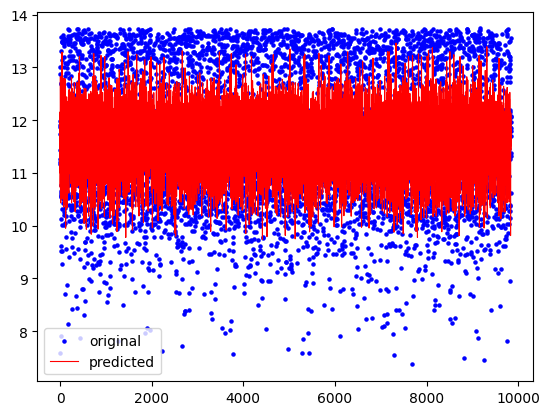

In [ ]:
#Idea from https://www.datatechnotes.com/2019/11/bayesian-ridge-regression-example-in.html
x_ax = range(len(log_test_y))
pyplot.scatter(x_ax, log_test_y, s=5, color="blue", label="original")
pyplot.plot(x_ax, log_tuned_bay_predict_test, lw=0.8, color="red", label="predicted")
pyplot.legend()
pyplot.show()

# Decision Tree Regression

Set up the training, testing, and validation datasets

In [69]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import ttest_ind
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ln_X_train = pd.read_csv('ln_data_train.csv')
ln_X_validate = pd.read_csv('ln_data_validate.csv')
ln_X_test = pd.read_csv('ln_data_test.csv')
ln_Y_train = ln_X_train['Amount']
ln_Y_validate = ln_X_validate['Amount']
ln_Y_test = ln_X_test['Amount']

Create and train the models (parameters have been tested separately)

In [70]:
#ln_model = DecisionTreeRegressor()
ln_model = DecisionTreeRegressor(max_depth = 5, random_state=1)
ln_model_proposed = DecisionTreeRegressor(criterion= "poisson", max_depth = 5, random_state=1)

ln_model.fit(ln_X_train, ln_Y_train)
ln_model_proposed.fit(ln_X_train, ln_Y_train)

DecisionTreeRegressor(criterion='poisson', max_depth=5, random_state=1)

Predict for validation set and calculate metrics

In [71]:
ln_pred = ln_model.predict(ln_X_validate)
ln_pred_proposed = ln_model_proposed.predict(ln_X_validate)

ln_Y_validate_arr = ln_Y_validate.to_numpy()

ln_rmse = np.sqrt(mean_squared_error(ln_Y_validate, ln_pred))
ln_mae = mean_absolute_error(ln_Y_validate, ln_pred)

ln_rmse_proposed = np.sqrt(mean_squared_error(ln_Y_validate, ln_pred_proposed))
ln_mae_proposed = mean_absolute_error(ln_Y_validate, ln_pred_proposed)



ln_t_statistic, ln_p_value = ttest_ind(ln_Y_validate_arr, ln_pred)
ln_t_statistic_proposed, ln_p_value_proposed = ttest_ind(ln_Y_validate_arr, ln_pred_proposed)


print(ln_rmse)
print(ln_mae)
print(ln_t_statistic)
print(ln_p_value)

print(ln_rmse_proposed)
print(ln_mae_proposed)
print(ln_t_statistic_proposed)
print(ln_p_value_proposed)

6581.386902719758
5247.1701542204
0.0319829803084478
0.9744859480348071
7254.665782920405
4853.82831949029
-0.010290255638887424
0.9917898131004527


Optionally display the generated tree

[Text(0.5, 0.9166666666666666, 'x[1] <= 12.502\npoisson = 92279.63\nsamples = 29524\nvalue = 187770.123'),
 Text(0.25, 0.75, 'x[1] <= 11.291\npoisson = 15943.41\nsamples = 23894\nvalue = 94183.457'),
 Text(0.125, 0.5833333333333334, 'x[1] <= 10.563\npoisson = 5387.792\nsamples = 10345\nvalue = 43562.309'),
 Text(0.0625, 0.4166666666666667, 'x[1] <= 9.827\npoisson = 2381.577\nsamples = 4479\nvalue = 23879.299'),
 Text(0.03125, 0.25, 'x[1] <= 9.078\npoisson = 1169.648\nsamples = 1294\nvalue = 10870.021'),
 Text(0.015625, 0.08333333333333333, 'poisson = 431.479\nsamples = 431\nvalue = 5181.889'),
 Text(0.046875, 0.08333333333333333, 'poisson = 272.255\nsamples = 863\nvalue = 13710.791'),
 Text(0.09375, 0.25, 'x[0] <= 28548.0\npoisson = 518.176\nsamples = 3185\nvalue = 29164.7'),
 Text(0.078125, 0.08333333333333333, 'poisson = 148.425\nsamples = 1470\nvalue = 24094.627'),
 Text(0.109375, 0.08333333333333333, 'poisson = 124.55\nsamples = 1715\nvalue = 33510.478'),
 Text(0.1875, 0.4166666666

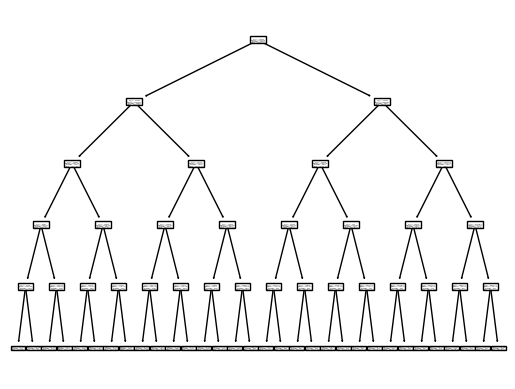

In [72]:
plot_tree(ln_model_proposed)

# Stepwise Regression

Import necessary libraries and read in preprocessed data files.

In [1]:
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
from stepwise_regression import step_reg
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

df = pd.read_csv("processed_data_train.csv")
df_validate = pd.read_csv("processed_data_validate.csv")
df_test = pd.read_csv("processed_data_test.csv")

We consider all features except for 'Amount' and 'log_Amount', then set 'log_Amount' to be the target variable. We will see which features significantly impact 'log_Amount the most'

In [2]:
# consider all features (independent variables) except for 'Amount' and 'log_Amount'
X = df.drop(['log_Amount', 'Amount'], axis=1)

# 'log_Amount' is the dependent variable here
# the goal is to see which independent variables signficantly impact the dependent variable
y = df['log_Amount']

# add a constant to intercept X
X = sm.add_constant(X)

Create a basic linear regression model using our variables. Compute the root mean squared error and mean absolute error to use for future comparison.

In [3]:
model = sm.OLS(y, X)
fit_model = model.fit()
# predict using all independent variables as features
baseline_predict = fit_model.predict(X)
df_test_y = df_test['log_Amount']
baseline_predict = baseline_predict[:len(df_test_y)]
# compute rmse and msa of baseline model predictions
baseline_mse = mean_squared_error(df_test_y, baseline_predict)
baseline_mae = mean_absolute_error(df_test_y, baseline_predict)
# displays the results of the model
print(fit_model.summary())
print("Baseline selection RMSE:", np.sqrt(baseline_mse))
print("Baseline selection MAE:", baseline_mae)

                            OLS Regression Results                            
Dep. Variable:             log_Amount   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     397.6
Date:                Tue, 07 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:46:35   Log-Likelihood:                -14103.
No. Observations:               29524   AIC:                         2.827e+04
Df Residuals:                   29494   BIC:                         2.852e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2

Use the step-reg library to perform backward selection on the features. Backselect will store a list of selected feature names sorted by significance to 'log_Amount' (highest to lowest).

In [4]:
backselect = step_reg.backward_regression(X, y, 0.05, verbose=False)
print(backselect)

['const', 'Severity', 'Age', 'Private Attorney', 'Gender', 'Anesthesiology', 'Dermatology', 'Emergency Medicine', 'Family Practice', 'General Surgery', 'Internal Medicine', 'Neurology/Neurosurgery', 'OBGYN', 'Occupational Medicine', 'Ophthamology', 'Orthopedic Surgery', 'Pathology', 'Pediatrics', 'Plastic Surgeon', 'Radiology', 'Resident', 'Urological Surgery', 'Medicare/Medicaid', 'No Insurance', 'Private', 'Workers Compensation', 'Divorced', 'Single', 'Married', 'Widowed']


Now we will create a new model using our new feature set from backward selection and test it on our test data. Compute the root mean squared error and mean absolute error.

In [5]:
X_backselect = X[backselect]
back_model = sm.OLS(y, X_backselect)
fit_back_model = back_model.fit()
# display the results of the model
print(fit_back_model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_Amount   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     427.0
Date:                Tue, 07 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:46:36   Log-Likelihood:                -14104.
No. Observations:               29524   AIC:                         2.826e+04
Df Residuals:                   29496   BIC:                         2.850e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2

Compute the root mean squared error and mean absolute error of the predictions on the test data.

In [6]:
# make predictions using the new model with selected features from backward selection
b_y_predict = fit_back_model.predict(X_backselect)
# use the testing set
b_y_predict = b_y_predict[:len(df_test_y)]
# calculate the root mean squared error and mean absolute error of the  predictions compared to the actual values
b_mse = mean_squared_error(df_test_y, b_y_predict)
b_mae = mean_absolute_error(df_test_y, b_y_predict)
# b_mse = mean_squared_error(y, b_y_predict)
# b_mae = mean_absolute_error(y, b_y_predict)
print("Backward selection RMSE:", np.sqrt(b_mse))
print("Backward selection MAE:", b_mae)

Backward selection RMSE: 0.5217251169557977
Backward selection MAE: 0.40812431181299164


Do the same process using the stepwise_regression library, except this time we will select our features using feature selection. In this case, forwardSelect will store a list of selected feature names sorted by significance to 'log_Amount' (highest to lowest).

In [7]:
forwardselect = step_reg.forward_regression(X, y, 0.05, verbose=False)
# print(forwardselect)

# now create a new model with the forward selected features
# ensure that predictors are significant (i.e p-value >0.05)
X_forwardselect = X[forwardselect]
forward_model = sm.OLS(y, X_forwardselect)
fit_forward_model = forward_model.fit()
# display the results of the model
print(fit_forward_model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_Amount   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     480.3
Date:                Tue, 07 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:46:45   Log-Likelihood:                -14105.
No. Observations:               29524   AIC:                         2.826e+04
Df Residuals:                   29499   BIC:                         2.847e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Severity                   0

Compute the root mean squared error and mean absolute error of the predictions on the test data.

In [8]:
# make predictions using the new model with selected features from forward selection
f_y_predict = fit_forward_model.predict(X_forwardselect)
f_y_predict = f_y_predict[:len(df_test_y)]
# calculate the root mean squared error and mean absolute error of the predictions compared to the actual values
f_mse = mean_squared_error(df_test_y, f_y_predict)
f_mae = mean_absolute_error(df_test_y, f_y_predict)
# f_mse = mean_absolute_error(y, f_y_predict)
# f_mse = mean_squared_error(y, f_y_predict)
print("Forward selection RMSE:", np.sqrt(f_mse))
print("Forward selection MAE:", f_mae)

Forward selection RMSE: 0.5217530337363838
Forward selection MAE: 0.4081277289841946


# Lasso Regression

Import necessary libraries

In [128]:
import sys
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import FastICA
from sklearn.preprocessing import PolynomialFeatures
from feature_engine.outliers import OutlierTrimmer

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy import stats

from sklearn.model_selection import cross_val_predict


Read in Data

In [141]:
# file_input = sys.argv[1]

# df = pd.read_csv(file_input)

# train_suffix = '_train.csv'
# validate_suffix = '_validate.csv'
# test_suffix = '_test.csv'

df_train = pd.read_csv('medicalmalpractice.csv_train.csv')
df_validate = pd.read_csv('medicalmalpractice.csv_validate.csv')
df_test = pd.read_csv('medicalmalpractice.csv_test.csv')

X_train = df_train.drop(columns=['Amount', 'log_Amount'])
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
y_test = df_test['log_Amount']

Default Lasso Regression:

Cross-Validation Results:
Mean Absolute Error (CV): 0.31002482236658097
Mean Squared Error (CV): 0.15269822102712946


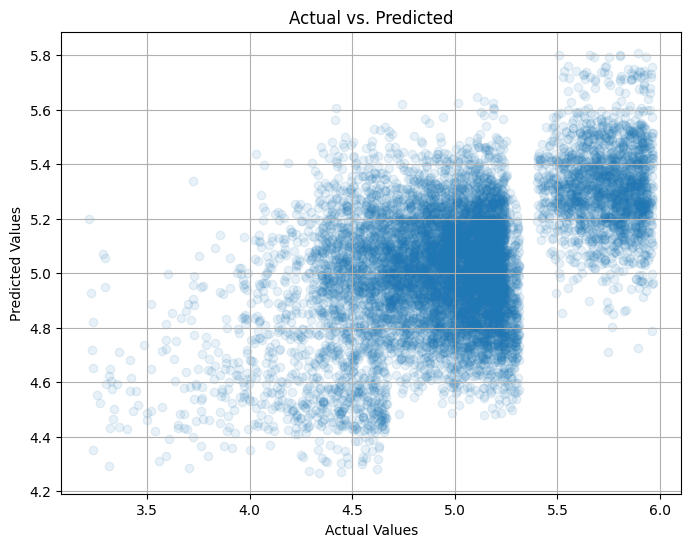

Test Results:
Mean Absolute Error (Test): 0.30585589500498434
Mean Squared Error (Test): 0.149223794794067


In [142]:
# Apply feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Lasso regression model
lasso = Lasso(alpha=0.001)

# Perform cross-validation on the scaled data
y_pred_cv = cross_val_predict(lasso, X_train_scaled, y_train, cv=10)

# Evaluate the model
mae_cv = mean_absolute_error(y_train, y_pred_cv)
mse_cv = mean_squared_error(y_train, y_pred_cv)

print("Cross-Validation Results:")
print(f"Mean Absolute Error (CV): {mae_cv}")
print(f"Mean Squared Error (CV): {mse_cv}")

# Fit the Lasso model to the entire training data (scaled)
lasso.fit(X_train_scaled, y_train)

# Make predictions on the test data (scaled)
y_pred = lasso.predict(X_test_scaled)

# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

# Evaluate the model on the test data
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Test Results:")
print(f"Mean Absolute Error (Test): {mae}")
print(f"Mean Squared Error (Test): {mse}")


Feature Implementation 1: Spline Transformer

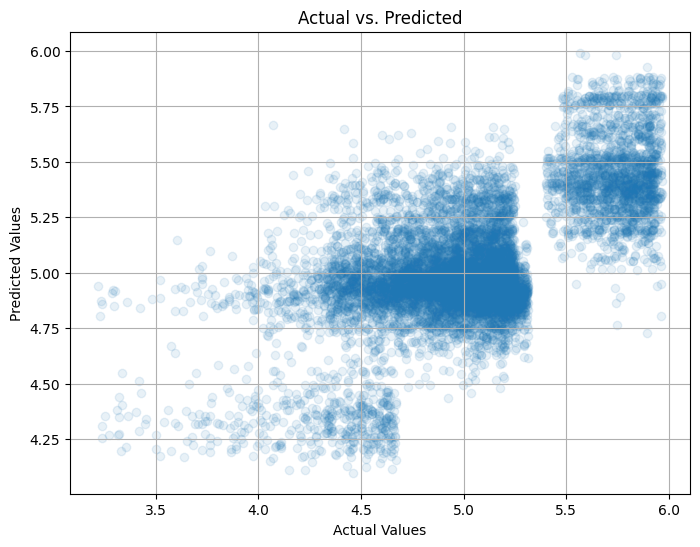

Mean Absolute Error: 0.2742379163766588
Mean Squared Error: 0.12163524134428395


In [135]:
# Read the data
df_train = pd.read_csv('medicalmalpractice.csv_train.csv')
df_test = pd.read_csv('medicalmalpractice.csv_test.csv')

X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']

X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

# Apply feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply polynomial transformation (if needed)
spline_transformer = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = spline_transformer.fit_transform(X_train_scaled)
X_test_poly = spline_transformer.transform(X_test_scaled)

# Create and fit the Lasso model
lasso = Lasso(alpha=0.001)
lasso.fit(X_train_poly, y_train)

# Make predictions on the test data
y_pred = lasso.predict(X_test_poly)

# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")


Feature Implementation 2: PCA

PCA:


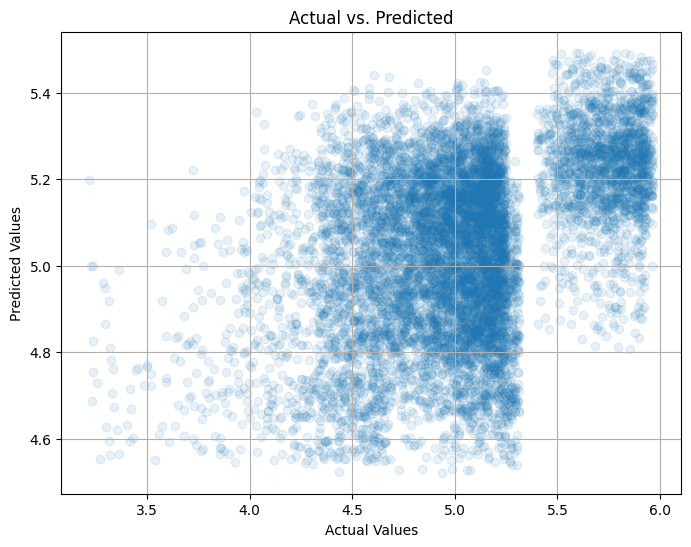

Mean Absolute Error: 0.3296696346692287
Mean Squared Error: 0.17119144313361995


In [143]:
# Read the data
df_train = pd.read_csv('medicalmalpractice.csv_train.csv')
df_test = pd.read_csv('medicalmalpractice.csv_test.csv')

X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']

X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

# Apply feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#pca
print("PCA:")
n_components = 2  # Number of principal components to retain
pca = PCA(n_components=n_components)
X_train_poly = pca.fit_transform(X_train_scaled)
X_test_poly = pca.transform(X_test_scaled)

# Create and fit the Lasso model
lasso = Lasso(alpha=0.001)
lasso.fit(X_train_poly, y_train)

# Make predictions on the test data
y_pred = lasso.predict(X_test_poly)

# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Feature Implementation 3: Power Transformer

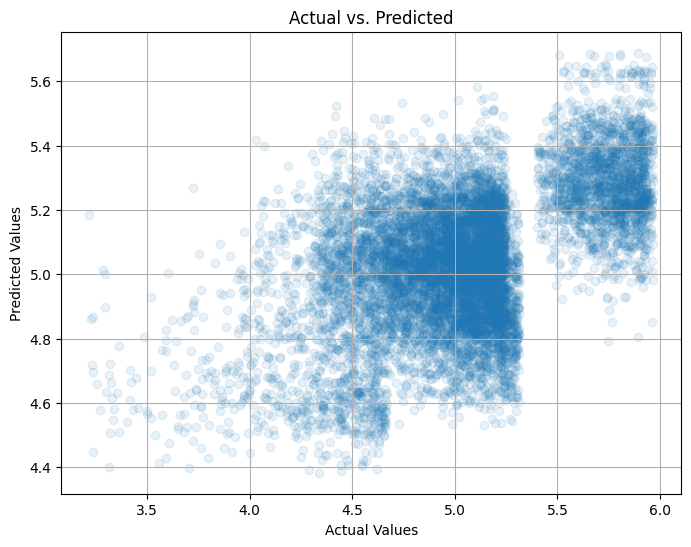

Test Results:
Mean Absolute Error (Test): 0.30747009351075816
Mean Squared Error (Test): 0.15083695095996197


In [144]:
# Read the data
df_train = pd.read_csv('medicalmalpractice.csv_train.csv')
df_test = pd.read_csv('medicalmalpractice.csv_test.csv')

# Separate the target variable and the features
X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

# Power transform the data
pt = PowerTransformer()
X_train_power = pt.fit_transform(X_train)
X_test_power = pt.transform(X_test)

# Apply feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_power)
X_test_scaled = scaler.transform(X_test_power)

# Create a Lasso regression model
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = lasso.predict(X_test_scaled)

# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Test Results:")
print(f"Mean Absolute Error (Test): {mae}")
print(f"Mean Squared Error (Test): {mse}")


Feature Implementation 4: Outlier Trimming

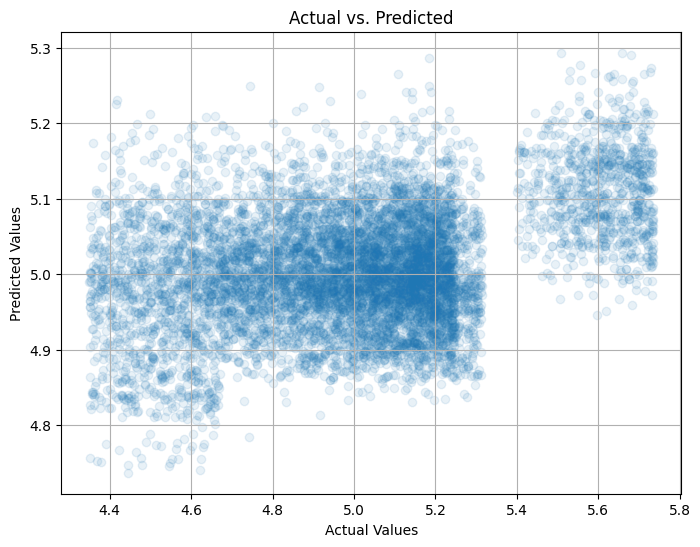

Test Results:
Mean Absolute Error (Test): 0.2372036214614601
Mean Squared Error (Test): 0.08677644969358592


In [146]:
# Read the data
df_train = pd.read_csv('medicalmalpractice.csv_train.csv')
df_test = pd.read_csv('medicalmalpractice.csv_test.csv')

# Outlier trimming
ot = OutlierTrimmer(capping_method='gaussian', tail='both', fold=1.5, variables=['log_Amount'])
ot.fit(df_train)
df_train = ot.transform(df_train)
df_test = ot.transform(df_test)

# Separate the target variable and the features
X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

# Apply feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Lasso regression model
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = lasso.predict(X_test_scaled)

# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel ("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Test Results:")
print(f"Mean Absolute Error (Test): {mae}")
print(f"Mean Squared Error (Test): {mse}")


Feature Implementation 5: t-SNE

In [148]:
# Read the data
df_train = pd.read_csv('medicalmalpractice.csv_train.csv')
df_test = pd.read_csv('medicalmalpractice.csv_test.csv')

# Separate the target variable and the features
X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

# Apply feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform t-SNE on the scaled data
n_components = 2  # Number of dimensions in the lower-dimensional space
tsne = TSNE(n_components=n_components, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_scaled)
X_test_tsne = tsne.fit_transform(X_test_scaled)

# Create a Lasso regression model
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_tsne, y_train)

# Make predictions on the test data (t-SNE transformed)
y_pred = lasso.predict(X_test_tsne)

# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Test Results:")
print(f"Mean Absolute Error (Test): {mae}")
print(f"Mean Squared Error (Test): {mse}")


AttributeError: 'TSNE' object has no attribute 'transform'